## Detector model: Kiukas / Ruschhaupt / Schmidt / Werner

In [1]:
from sympy import *
#from sympy.physics.matrices import mdft
from sympy.physics.quantum import TensorProduct
from sympy.functions.special.delta_functions import Heaviside
from sympy.physics.quantum.dagger import Dagger

from sympy.stats import ContinuousRV, variance, std

from sympy.plotting import plot, plot3d_parametric_line

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['text.usetex'] = False

# https://matplotlib.org/gallery/mplot3d/lines3d.html?highlight=parametric
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


In [2]:
gamma = Symbol('gamma', real=True)
t = Symbol('t', real=True)
tprime = Symbol('t\'', real=True)
omega = Symbol('omega', real=True)
nu = Symbol('nu', real=True)

In [3]:
def D(_gamma):
    return Rational(1, 2) * Matrix([
        [0, 0],
        [0, _gamma]
    ])

In [4]:
H = Matrix ([
[0, 1] ,
[1, 0]
])

In [5]:
init_printing ()


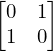

In [6]:
H

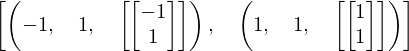

In [7]:
H.eigenvects()

It's manually seen that $\langle H \rangle = 0$ and $\langle H^2 \rangle = 1$, therefore $\sigma_{H} = 1$.

In [8]:
def K(_gamma):
    return H - I*D(_gamma)

In [9]:
def B(_gamma):
    return lambda t: exp(-I*K(_gamma)*t)

In [10]:
def U():
    return lambda t: exp(-I*H*t)

In [11]:
GAMMA = Rational(1, 1001)

In [35]:
def non_unitary_psi(_t):
    return B(gamma)(_t) * Matrix([1,0])

In [36]:
def unitary_psi(_t):
    return U()(_t) * Matrix([1,0])

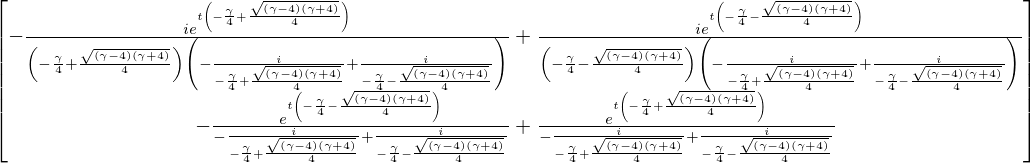

In [37]:
non_unitary_psi(t)

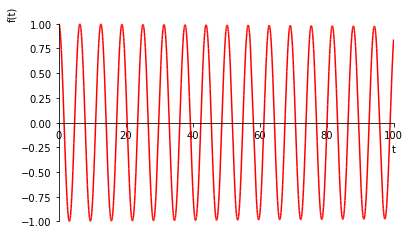

In [15]:
plot(re(non_unitary_psi(t)[0]), (t, 0, 100), line_color='r')

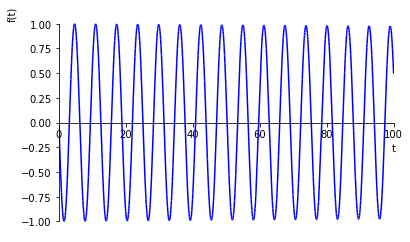

In [16]:
plot(im(non_unitary_psi(t)[1]), (t, 0, 100), line_color='b')

In [38]:
def lossy_norm(_t):
    psi = B(gamma)(_t) * Matrix([1,0])
    return (abs(psi[0])**2 + abs(psi[1])**2)

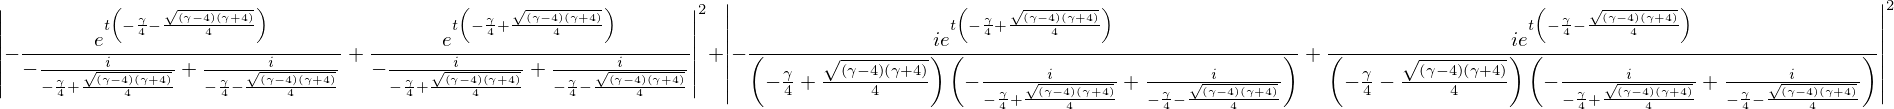

In [39]:
lossy_norm(t)

In [19]:
non_unitary_psi_n = lambdify(t, non_unitary_psi(t), "numpy")

In [20]:
_lossy_norm_n = lambdify(t, lossy_norm(t), "numpy")
def lossy_norm_n(__t):
    # prevent a warning, even if we know it's real
    return np.real(_lossy_norm_n(__t))

In [21]:
lossy_norm_n

<function __main__.lossy_norm_n>

In [22]:
def non_unitary_psi_renorm_n(_t):
    return non_unitary_psi_n(_t) / np.sqrt(lossy_norm_n(_t))

In [23]:
T = np.linspace(1e-16, 100, 2000)

Text(0.5,0,'t')

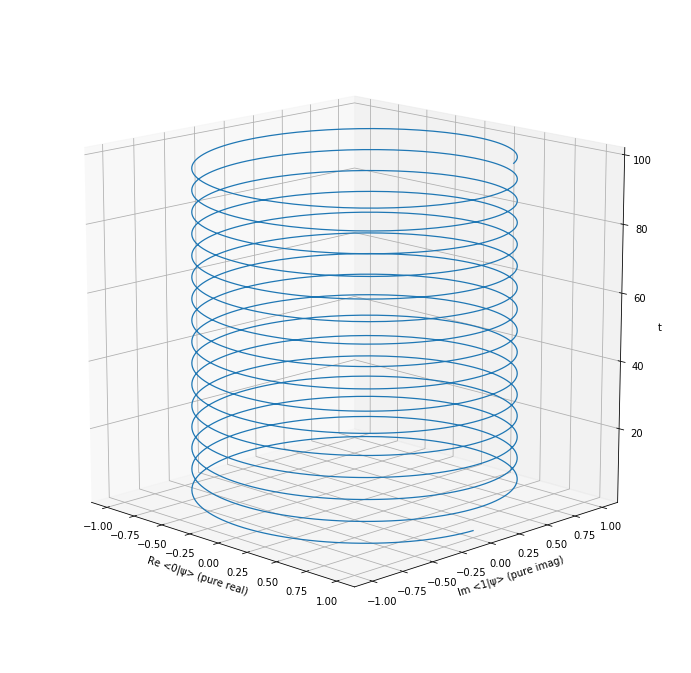

In [24]:
fig = plt.figure(figsize=(12,12))

ax = fig.gca(projection='3d')
ax.view_init(15,-45) # rotate 3d point of view

ax.plot(
    np.real(non_unitary_psi_n(T)[0][0]), np.imag(non_unitary_psi_n(T)[1][0]), T,
    linewidth=1.25
)

##ax.legend()

plt.xlabel('Re <0|\u03C8> (pure real)')
plt.ylabel('Im <1|\u03C8> (pure imag)')
ax.set_zlabel('t')


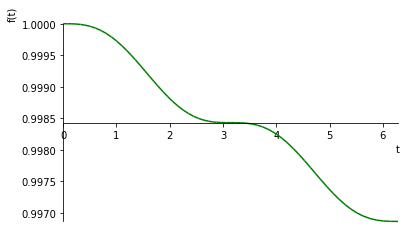

In [25]:
plot(lossy_norm(t),(t, 0, 2*pi), line_color='g')

In [40]:
def prob_0_unitary(t):
    return abs(unitary_psi(t)[0]**2)

In [41]:
def prob_1_unitary(t):
    return abs(unitary_psi(t)[1]**2)

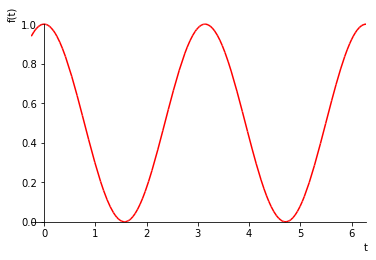

In [28]:
plot(prob_0_unitary(t),(t, -0.25, 2*pi), line_color='r')

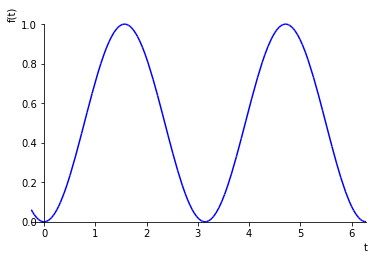

In [29]:
plot(prob_1_unitary(t),(t, -0.25, 2*pi), line_color='b')

In [30]:
X = np.linspace(1e-6, 2*np.pi, 1000)  # avoid singularity in t=0

In [31]:
Y = lossy_norm_n(X)

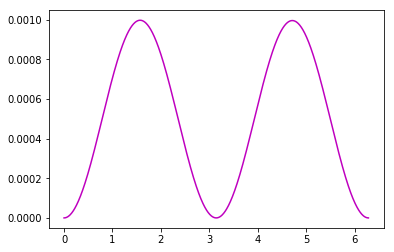

In [32]:
plt.plot(X, -np.gradient(Y, X), 'm')

In [44]:
# we have set gamma = 2*sqrt(2)
def hatpsi(_t):
    return \
        Heaviside(_t) * \
        sympify(2)**(Rational(3, 4)) * \
        Matrix([
            [0, 0],
            [0, 1]
        ]) * \
        non_unitary_psi(_t)
        
def hatpsi_n(_t):
    return \
        np.heaviside(_t, 0) * \
        2**(3/4) * \
        np.array([
            [0, 0],
            [0, 1]
        ]) * \
        non_unitary_psi_n(_t)
        
        
    

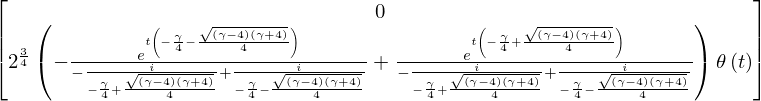

In [45]:
hatpsi(t)

In [46]:
def hatpsisquarednorm(_t):
    return abs(hatpsi(_t)[0])**2 + abs(hatpsi(_t)[1])**2

#def hatpsisquarednorm_n(_t):
#    return abs(hatpsi_n(_t)[0]**2) + abs(hatpsi_n(_t)[1]**2)

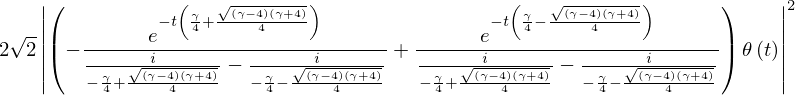

In [48]:
hatpsisquarednorm(t)

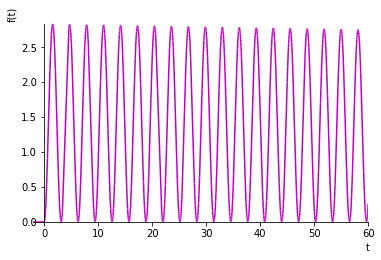

In [263]:
plot(hatpsisquarednorm(t), (t, -2, 60), line_color='m')

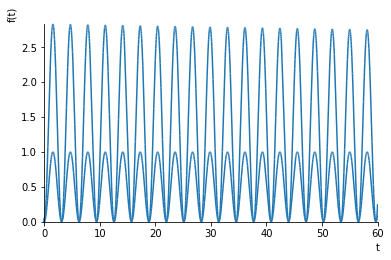

In [264]:
plot(prob_1_detect(t), hatpsisquarednorm(t), (t, -0.25, 60))

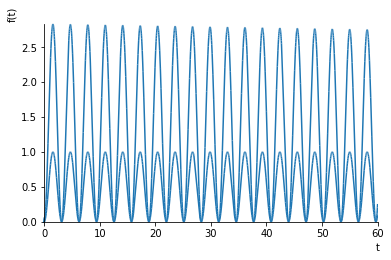

In [265]:
plot(prob_1_unitary(t), hatpsisquarednorm(t), (t, -0.25, 60))

In [266]:
def prob_0_hatpsi(_t):
    return abs(hatpsi(_t)[0]**2) / (abs(hatpsi(_t)[0]**2) + abs(hatpsi(_t)[1]**2))

In [267]:
def prob_1_hatpsi(_t):
    return abs(hatpsi(_t)[1]**2) / (abs(hatpsi(_t)[0]**2) + abs(hatpsi(_t)[1]**2))

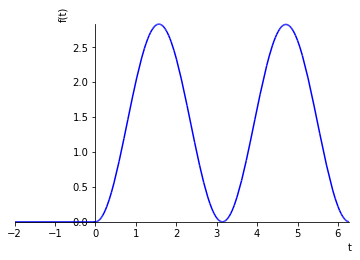

In [268]:
plot( abs(hatpsi(t)[1]**2), (t, -2, 2*pi), line_color='b')

In [271]:

# TODO: switch to numeric and use FFT 
# https://docs.scipy.org/doc/numpy-1.15.0/reference/routines.fft.html#real-and-hermitian-transforms
# The below takes ages to complete


def fhatpsi1(_nu):
    return fourier_transform(hatpsi(t)[1], t, _nu)

In [ ]:
plot(abs(fhatpsi1(nu))**2, (nu, -1, 1), line_color='#bbbbbb')

The above Fourier transform is defined in frequency (\nu) not angular frequency (\omega),
therefore needs rescaling.

In [ ]:
def fhatpsiomega(_omega):
    return fhatpsi1(_omega/(2*pi)) / sqrt((2*pi))

In [ ]:
plot(abs(fhatpsiomega(omega))**2, (omega, -2*pi, 2*pi), line_color='magenta')

In [ ]:
# graphical comparison with a normalized gaussian
sigma = 1.0
plot((1/(sqrt(2*pi)*sigma)) * exp(-omega**2/(2*(sigma)**2)), (omega, -2*pi, 2*pi), line_color='magenta')

## (Discrete) Page-Wootters model

In [57]:
from scipy.linalg import dft, norm, expm
from scipy import stats

In [58]:
T = np.diag(np.arange(0,32)) * np.pi / 16

In [59]:
# The NumPy Fourier matrix is the conjugate of Mathematica's one,
# hence the trailing .conj() 
F = dft(32, scale='sqrtn').conj()

In [60]:
F_dagger = F.conj().T

In [61]:
Omega = F @ T @ F_dagger * 16 / np.pi

In [62]:
oeigenvalues, oeigenvectors = np.linalg.eig(Omega)

In [63]:
np.round(oeigenvalues)

array([31.-0.j, -0.-0.j, 30.-0.j,  1.-0.j, 29.-0.j,  2.-0.j, 28.+0.j,
        3.+0.j, 27.+0.j,  4.+0.j, 26.+0.j,  5.+0.j, 25.-0.j,  6.-0.j,
       24.-0.j, 23.+0.j,  7.-0.j, 22.+0.j,  8.+0.j, 21.-0.j,  9.+0.j,
       20.-0.j, 10.+0.j, 19.+0.j, 18.-0.j, 11.+0.j, 17.+0.j, 16.+0.j,
       12.+0.j, 15.-0.j, 14.+0.j, 13.-0.j])

In [64]:
H = np.array([
    [0, 1],
    [1, 0]
])

In [65]:
D = np.array([
    [0, 0],
    [0, np.sqrt(2)]
])

In [66]:
K = H - 1j*D

In [67]:
K

array([[0.+0.j        , 1.+0.j        ],
       [1.+0.j        , 0.-1.41421356j]])

In [68]:
J = np.kron(Omega, np.eye(2)) + np.kron(np.eye(32), K)

In [69]:
eigenvalues, eigenvectors = np.linalg.eig(J)

In [70]:
EnergyCorrectionMatrices = np.zeros((64, 64, 64), np.complex)
for n in range(64):
    EnergyCorrectionMatrices[n] = np.kron(
        expm(-1j*eigenvalues[n]*T),
        np.eye(2)
    )
# TODO: DRY
EnergyCorrectionMatricesT = np.zeros((64, 32, 32), np.complex)
for n in range(64):
    EnergyCorrectionMatricesT[n] = expm(-1j*eigenvalues[n]*T)


In [71]:
def history_vector(eigenindex):
    # Needs matrix transposition ".T" (different convention as opposed to Mathematica)
    eigenvector = eigenvectors.T[eigenindex]
    return EnergyCorrectionMatrices[eigenindex] @ eigenvector

# "unflatten" the history_vector v into a a sequence of qubit component pairs
def reshape(v):
    return np.reshape(v, (-1,2))

# also make the first component real
def normalize_initial(v):
    vout = np.zeros(64, np.complex)
    # A phase factor to make it real
    vout = v * np.exp(-1j * np.angle(v[0]))
    # And a factor to normalize the initial state
    vout = vout / sqrt(
        np.abs(vout[0]**2) + np.abs(vout[1]**2)
    )
    return vout

In [72]:
# Find the best linear combination to obtain |0> as initial state
def find_best():
    max_prob0 = 0
    max_prob0_i = 0
    max_prob0_j = 0
    for i in range(32):
        for j in range(32):
            qbi = reshape(history_vector(i))
            qbj = reshape(history_vector(j))
            qbit_hist = qbi + qbj
            prob0 = np.abs(qbit_hist[0][0]**2) / (
                np.abs(qbit_hist[0][0]**2) + np.abs(qbit_hist[0][1]**2)
            )
            if prob0 > max_prob0:
                max_prob0 = prob0
                max_prob0_i = i
                max_prob0_j = j
    print (max_prob0_i, max_prob0_j, max_prob0)
    return (max_prob0_i, max_prob0_j)
    

In [73]:
# start with |0> as close as possible
i, j = find_best()
qbhistvec = normalize_initial(history_vector(i) + history_vector(j))
qbhist = reshape(qbhistvec) 

2 7 1.0


In [74]:
qbhist = qbhist.astype(complex)

Consitently with "odinary QM" findings, the component along |0> stays purely real, and the component along |1> stays purely imaginary.

In [75]:
# Fill data for plotting
times = np.arange(0, 2*np.pi, np.pi/16)
norms = np.zeros(32)
probs0 = np.zeros(32)
probs1 = np.zeros(32)
# Components 0 are pure real, componets 1 are pure imag
real_parts0 = np.real(qbhist.T[0])
imag_parts1 = np.imag(qbhist.T[1])

for i in range(0, 32):
    norms[i] = (np.abs(qbhist[i][0]**2) + np.abs(qbhist[i][1]**2))
    probs0[i] = np.abs(qbhist[i][0]**2) / (
        np.abs(qbhist[i][0]**2) + np.abs(qbhist[i][1]**2) )
    probs1[i] = np.abs(qbhist[i][1]**2) / (
        np.abs(qbhist[i][0]**2) + np.abs(qbhist[i][1]**2) )

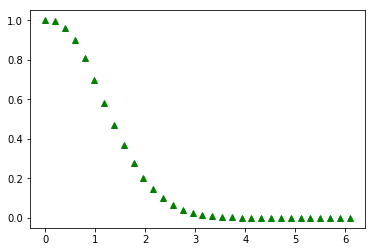

In [76]:
plt.plot(times, norms/norms[0], 'g^')

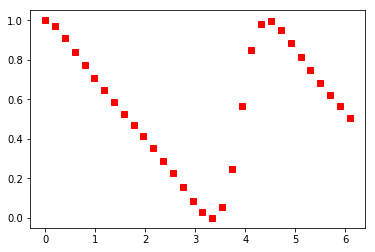

In [77]:
plt.plot(times, probs0, 'rs')

Text(0.5, 0, 't')

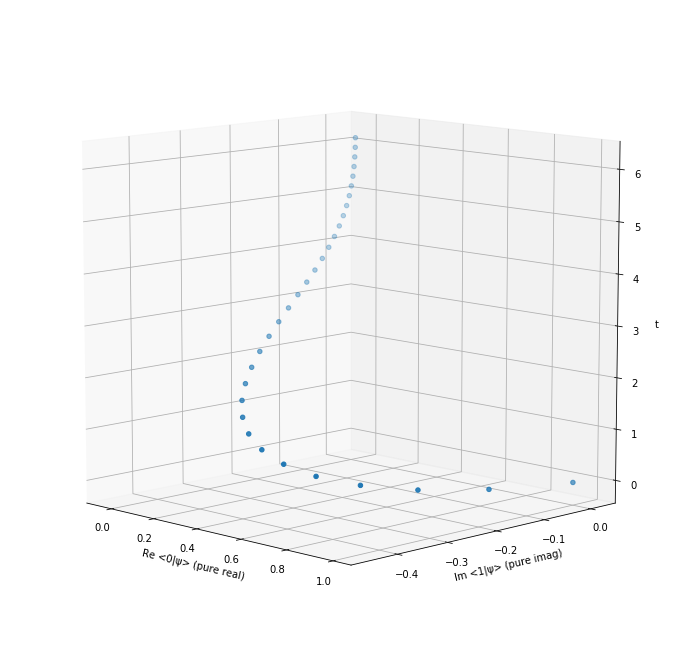

In [78]:
fig = plt.figure(figsize=(12,12))

#ax = fig.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.view_init(10,-45) # rotate 3d point of view

ax.scatter(
    real_parts0, imag_parts1, times
)

##ax.legend()

plt.xlabel('Re <0|\u03C8> (pure real)')
plt.ylabel('Im <1|\u03C8> (pure imag)')
ax.set_zlabel('t')


## Detection event

In [79]:
sqr2D = np.array([
    [0, 0],
    [0, 2**(3/4)]
])

In [80]:
qbhistvec = qbhistvec.astype(np.complex)

In [81]:
sqr2D = sqr2D.astype(np.complex)

In [82]:
#prob_detect_v = np.kron(np.eye(32), sqr2D) @ qbhistvec
#
# More direct route, without going through histories
i, j = find_best()
prob_detect_v = \
    (np.kron(EnergyCorrectionMatricesT[i], sqr2D) @ eigenvectors.T[i]) + \
    (np.kron(EnergyCorrectionMatricesT[j], sqr2D) @ eigenvectors.T[j])

# normalize
prob_detect_v = prob_detect_v / norm(prob_detect_v)



2 7 1.0


In [83]:
prob_detect = np.zeros(32)
for t_idx in range(32):
    prob_detect[t_idx] = \
        np.abs(prob_detect_v[2*t_idx])**2 + np.abs(prob_detect_v[2*t_idx+1])**2

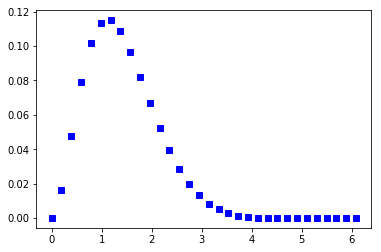

In [84]:
plt.plot(times, prob_detect, 'bs')

In [85]:
detect_fft = \
    np.kron(F, np.eye(2)) @ prob_detect_v
detect_fft = detect_fft / norm(detect_fft)

In [86]:
prob_detect_fft = np.zeros(32)
for o in range(32):
    prob_detect_fft[o] = \
        np.abs(detect_fft[2*o]**2) + \
        np.abs(detect_fft[2*o + 1]**2) 

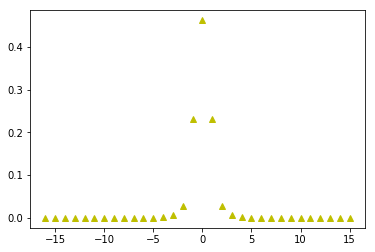

In [87]:
# Arrays are "rolled" because the second half 
# of the spectrum is identified with
# negative frequencies.
plt.plot(range(-16, 16), np.roll(prob_detect_fft, -16), 'y^')

In [88]:
S_t = stats.entropy(prob_detect)

In [89]:
S_omega = stats.entropy(prob_detect_fft)

In [90]:
S_t

In [91]:
S_omega

In [92]:
S_t * S_omega

In [93]:
np.log(32)

In [94]:
(S_t * S_omega - np.log(32)) / np.log(32)

Only 1.8% more than the minumum per entropic uncertainty relation.

### Use Scipy routines to compute sigmas

In [95]:

xk = range(-16,16)
pk = np.roll(prob_detect_fft, -16)
detect_fft_pdist = stats.rv_discrete(name='prob_detect_fft_minus16', values=(xk, pk))

In [96]:
sigma_omega = detect_fft_pdist.std()

In [97]:
xk = times
pk = prob_detect
detect_pdist = stats.rv_discrete(name='prob_detect', values=(xk, pk))

In [98]:
sigma_t = detect_pdist.std()

In [99]:
sigma_t * sigma_omega

It's still quite a bit more than 0.5, i.e. the minimum uncertainty...

But this is in fact consistent with the paper.